In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.cluster import KMeans

In [20]:
from hmmlearn import hmm
from sklearn.linear_model import LinearRegression

In [8]:
df = pd.read_csv("/data/pavnet/2025/PIURA/PIU_AMPLITUDE_2025-05-27-to-2025-06-30.csv", index_col=[0],parse_dates=[0])

# 12:00–22:00 daily
df = df[(df.index.hour >= 12) & (df.index.hour < 22)]

daily_sequences = []
for day, group in df.groupby(df.index.date):
    daily_sequences.append(group["NAA-filt"].values)  

max_len = max(len(seq) for seq in daily_sequences)
padded_sequences = np.array([np.pad(seq, (0, max_len - len(seq)), mode='constant', constant_values=np.nan) for seq in daily_sequences])

In [16]:
padded_sequences.shape

(30, 3706)

Text(0, 0.5, 'Log_A')

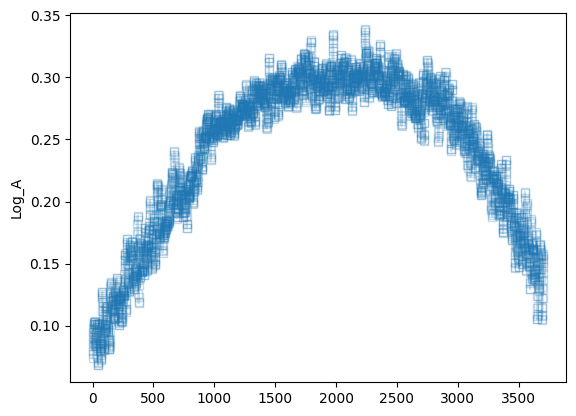

In [175]:
plt.plot(np.log10(padded_sequences[2]), marker="s", markerfacecolor="none", alpha=0.25)
plt.ylabel("Log_A")

In [184]:
padded_sequences.shape

(30, 3706)

In [189]:
def create_ar_features(sequences, p=2):
    X, y = [], []
    for seq in sequences:
        for t in range(p, len(seq)):
            X.append(seq[t-p:t])
            y.append(seq[t])
    return np.array(X), np.array(y)

class ARHMM(hmm.GaussianHMM):
    def __init__(self, n_components=3, p=1, n_iter=10,**kwargs):
        super().__init__(n_components=n_components, **kwargs)
        self.p = p
        self.ar_coeffs = None
        self.n_iter = n_iter
        self.startprob_ = np.ones(self.n_components) / self.n_components
    
    def fit(self, X, y):
        #super().fit(y.reshape(-1, 1)) # fit with gaussian 
        # INITIAL APPROXIMATIUON USING KMEANS
        kmeans = KMeans(n_clusters=self.n_components)
        states = kmeans.fit_predict(X)
        self.ar_coeffs = []
        for state in range(self.n_components):
            mask = (states==state)
            if np.sum(mask) > self.p:
                lr = LinearRegression()
                lr.fit(X[mask], y[mask])
                self.ar_coeffs.append(lr.coef_)
            else:
                self.ar_coeffs.append(np.zeros(self.p))
    
        self.means_ = np.array([np.mean(y[states == s]) for s in range(self.n_components)]).reshape(-1, 1)
        self.covars_ = np.array([np.var(y[states == s]) for s in range(self.n_components)]).reshape(-1, 1)
        #self.covars_ = self.covars_.reshape(-1, 1)
        self.transmat_ = np.ones((self.n_components, self.n_components)) / self.n_components
        #self._check()
        self.n_features = self.means_.shape[0]
        self._fit_ar_hmm(X, y, self.n_iter)
    
    def _fit_ar_hmm(self, X, y, n_iter):
        for _ in range(n_iter):
            # E step : expectation
            log_prob = self._compute_likelihood(X)
            log_alpha, log_scaling = self._do_forward_pass(log_prob)
            log_beta = self._do_backward_pass(log_prob, log_scaling)
            log_gamma = log_alpha + log_beta

            # M step 
            for state in range(self.n_components):
                mask = np.exp(log_gamma[:, state]) >0.1
                if np.sum(mask) > self.p:
                    lr = LinearRegression()
                    lr.fit(X[mask], y[mask])
                    self.ar_coeffs[state] = lr.coef_.flatten()
                    self.covars_[state] = np.mean((y[mask] - lr.predict(X[mask])))**2
                    
                    


    def _do_forward_pass(self, log_prob):
        n_samples, n_components = log_prob.shape
        log_alpha = np.full((n_samples, n_components), -np.inf)
        log_scaling = np.zeros(n_samples)

        log_alpha[0] = np.log(self.startprob_) + log_prob[0]
        log_scaling[0] = np.logaddexp.reduce(log_alpha[0])
        log_alpha -= log_scaling[0]
        for t in range(1, n_samples): #from t=1
            for j in range(model.n_components):
                log_transitions = np.log(self.transmat_[:, j])+ \
                                            log_alpha[t-1]
                log_sum = np.logaddexp.reduce(log_transitions)
                log_alpha[t, j] = log_sum + log_prob[t, j]
            log_scaling[t] = np.logaddexp.reduce(log_alpha[t])
            log_alpha[t] -= log_scaling[t]
        return log_alpha, log_scaling

    def _do_backward_pass(self, log_prob, log_scaling):
        n_samples, n_components = log_prob.shape
        log_beta = np.full((n_samples, n_components), -np.inf)
        log_beta[-1] = .0
        for t in range(n_samples - 2, -1, -1):
            for i in range(n_components):
                # log-sum-exp
                log_transitions = np.log(self.transmat_[i, :]) + \
                                    log_prob[t+1] + log_beta[t+1]
                log_beta[t, i] = np.logaddexp.reduce(log_transitions)
            log_beta[t] = log_scaling[t+1]
        return log_beta
    
    def _compute_likelihood(self, X):
        n_samples = X.shape[0]
        log_prob = np.zeros((n_samples, self.n_components))
        for t in range(self.p, n_samples):
            x_window = X[t]#X[t-self.p:t].flatten()  # Ensure 1D array of length p
            
            for state in range(self.n_components):
                
                pred = np.dot(x_window, self.ar_coeffs[state])
                if isinstance(X[t], (np.ndarray, list)):
                    current_obs = X[t][0] if len(X[t]) > 0 else 0
                else:
                    current_obs = X[t]
                log_prob[t, state] = norm.logpdf(current_obs, 
                                               pred,
                                               np.sqrt(self.covars_[state, 0]))
        print(log_prob)
        return log_prob

In [186]:
import numpy as np
from scipy.stats import norm
from hmmlearn import hmm
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

class ARHMM(hmm.GaussianHMM):
    def __init__(self, n_components=3, p=1, n_iter=10, **kwargs):
        super().__init__(n_components=n_components, covariance_type='diag', **kwargs)
        self.p = p
        self.n_iter = n_iter
        self.ar_coeffs = None
        self.n_features = 1  # Univariate data

    def _compute_likelihood(self, X):
        n_samples = X.shape[0]
        log_prob = np.zeros((n_samples, self.n_components))
        
        for t in range(self.p, n_samples):
            # Get the window of past observations
            x_window = X[t-self.p:t].flatten()  # Ensure 1D array of length p
            
            for state in range(self.n_components):
                # Calculate prediction
                print(x_window.shape, self.ar_coeffs[state].shape)
                pred = np.dot(x_window, self.ar_coeffs[state])
                
                # Get current observation value
                if isinstance(X[t], (np.ndarray, list)):
                    current_obs = X[t][0] if len(X[t]) > 0 else 0
                else:
                    current_obs = X[t]
                
                # Calculate log probability
                
                log_prob[t, state] = norm.logpdf(current_obs, 
                                               pred,
                                               np.sqrt(self.covars_[state, 0]))
        return log_prob

    def fit(self, X, y):
        # Initialize with proper shapes
        self.startprob_ = np.ones(self.n_components)/self.n_components
        self.transmat_ = np.ones((self.n_components, self.n_components))/self.n_components
        
        # Initialize AR coefficients
        kmeans = KMeans(n_clusters=self.n_components)
        states = kmeans.fit_predict(X)
        
        self.ar_coeffs = []
        for state in range(self.n_components):
            mask = (states == state)
            if np.sum(mask) > self.p:
                lr = LinearRegression()
                lr.fit(X[mask], y[mask])
                self.ar_coeffs.append(lr.coef_.flatten())  # Ensure shape (p,)
            else:
                self.ar_coeffs.append(np.zeros(self.p))
        
        # Initialize parameters
        self.means_ = np.array([np.mean(y[states == s]) 
                              for s in range(self.n_components)]).reshape(-1, 1)
        self.covars_ = np.array([np.var(y[states == s]) 
                               for s in range(self.n_components)]).reshape(-1, 1)
        
        # Run EM
        self._fit_ar_hmm(X, y)
        
    def _fit_ar_hmm(self, X, y):
        for _ in range(self.n_iter):
            # E-step
            log_prob = self._compute_likelihood(X)
            log_alpha, log_scaling = self._do_forward_pass(log_prob)
            log_beta = self._do_backward_pass(log_prob, log_scaling)
            log_gamma = log_alpha + log_beta
            
            # M-step
            for state in range(self.n_components):
                mask = np.exp(log_gamma[:, state]) > 0.1
                if np.sum(mask) > self.p:
                    lr = LinearRegression()
                    lr.fit(X[mask], y[mask])
                    self.ar_coeffs[state] = lr.coef_.flatten()
                    residuals = y[mask] - lr.predict(X[mask])
                    self.covars_[state, 0] = np.mean(residuals**2)

In [164]:
nstates = 2
order = 3

In [188]:
X[3]

array([1.31871446, 1.31648598, 1.31141982])

In [187]:
X, y = create_ar_features(daily_sequences, p=order) 

model = ARHMM(n_components=nstates, p=order)
model.fit(X,y)

(9,) (3,)


ValueError: shapes (9,) and (3,) not aligned: 9 (dim 0) != 3 (dim 0)

In [158]:
states = model.predict(y.reshape(-1, 1))

last_obs = y[-order:]
next_state = model.transmat_[states[-1]].argmax()

next_pred = np.dot(last_obs, model.ar_coeffs[next_state])

In [155]:
y.reshape(-1, 1)

array([[1.30789869],
       [1.31627726],
       [1.31871446],
       ...,
       [1.54647251],
       [1.53801382],
       [1.53424176]], shape=(110959, 1))

Text(0.5, 1.0, 'AR-Ord: 4, States: [2 2 2 ... 2 2 2]')

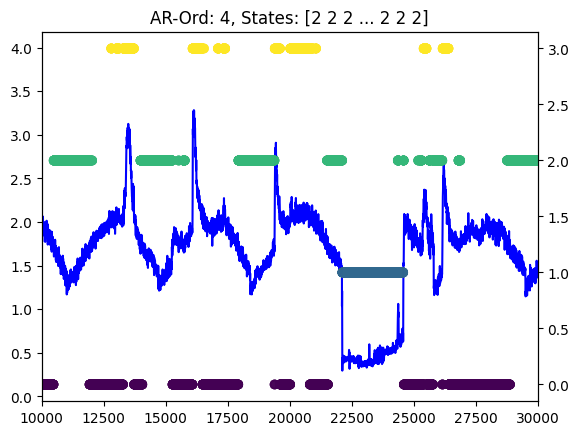

In [77]:
ax = plt.gca()
plt.plot(y, color="blue", zorder=0)
ax2 = ax.twinx()
for s in np.unique(states):
    
    #ax2.scatter(np.arange(len(states)), states, c=states, zorder=1, alpha=0.4)
#plt.plot(states)
plt.xlim(10e3, 30e3)
plt.title(f"AR-Ord: {order}, States: {states}")

Text(0.5, 1.0, 'AR-Ord: 1, States: [2 2 2 ... 2 2 2]')

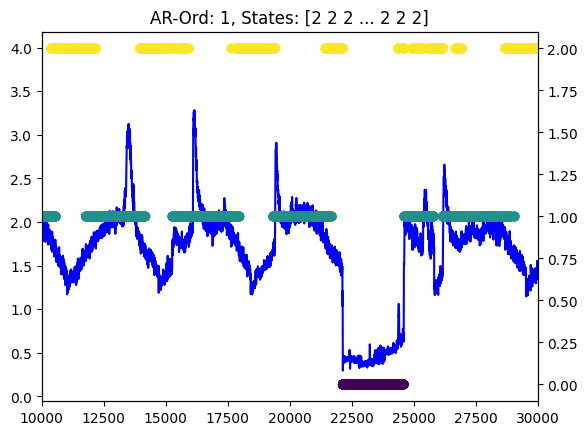

In [159]:
ax = plt.gca()
plt.plot(y, color="blue", zorder=0)
ax2 = ax.twinx()
for s in np.unique(states):
    
    ax2.scatter(np.arange(len(states)), states, c=states, zorder=1, alpha=0.4)
#plt.plot(states)
plt.xlim(10e3, 30e3)
plt.title(f"AR-Ord: {order}, States: {states}")

In [90]:
kmeans = KMeans(n_clusters=nstates)
states = kmeans.fit_predict(X)

Text(0.5, 1.0, 'AR-Ord: 4, States: [2 2 2 ... 2 2 2]')

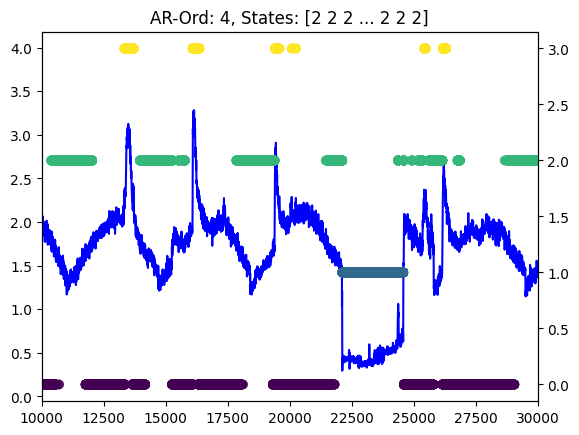

In [93]:
ax = plt.gca()
plt.plot(y, color="blue", zorder=0)
ax2 = ax.twinx()
for s in np.unique(states):
    
    ax2.scatter(np.arange(len(states)), states, c=states, zorder=1, alpha=0.4)
#plt.plot(states)
plt.xlim(10e3, 30e3)
plt.title(f"AR-Ord: {order}, States: {states}")

In [90]:
kmeans = KMeans(n_clusters=nstates)
states = kmeans.fit_predict(X)

Text(0.5, 1.0, 'AR-Ord: 4, States: [2 2 2 ... 2 2 2]')

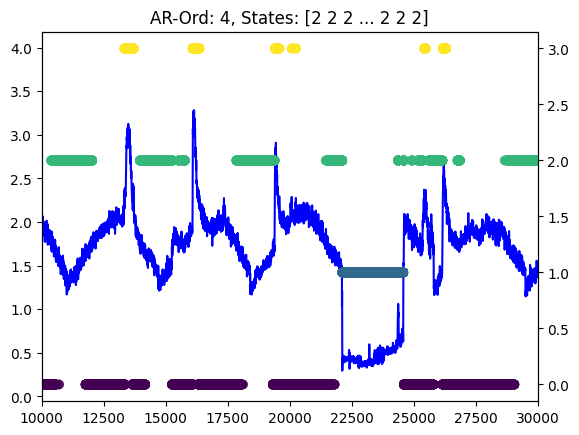

In [93]:
ax = plt.gca()
plt.plot(y, color="blue", zorder=0)
ax2 = ax.twinx()
for s in np.unique(states):
    
    ax2.scatter(np.arange(len(states)), states, c=states, zorder=1, alpha=0.4)
#plt.plot(states)
plt.xlim(10e3, 30e3)
plt.title(f"AR-Ord: {order}, States: {states}")

In [94]:
X

array([[1.29345036, 1.30789869, 1.31627726, 1.31871446],
       [1.30789869, 1.31627726, 1.31871446, 1.31648598],
       [1.31627726, 1.31871446, 1.31648598, 1.31141982],
       ...,
       [1.61432645, 1.59736566, 1.57791708, 1.56008683],
       [1.59736566, 1.57791708, 1.56008683, 1.54647251],
       [1.57791708, 1.56008683, 1.54647251, 1.53801382]],
      shape=(110869, 4))